# **DeepBedMap**

Predicting the bed elevation of Antarctica using our trained Super Resolution Deep Neural Network.
The results will be compared against other interpolated grid products along groundtruth tracks in small regions.
Finally we will produce an Antarctic-wide DeepBedMap Digital Elevation Model (DEM) at the very end!

In [1]:
import dataclasses
import math
import os
import typing

os.environ["CUDA_VISIBLE_DEVICES"] = ""

import xarray as xr
import salem

import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd
import pygmt as gmt
import quilt
import rasterio
import skimage

import comet_ml
import chainer
import cupy

from features.environment import _load_ipynb_modules, _download_model_weights_from_comet

data_prep = _load_ipynb_modules("data_prep.ipynb")

# 1. Gather datasets

## 1.1 Get bounding box of our area of interest

Basically predict on an place where we have groundtruth data to validate against.

In [2]:
def get_image_with_bounds(filepaths: list, indexers: dict = None) -> xr.DataArray:
    """
    Retrieve raster image in xarray.DataArray format patched
    with projected coordinate bounds as (xmin, ymin, xmax, ymax)

    Note that if more than one filepath is passed in,
    the output groundtruth image array will not be valid
    (see https://github.com/pydata/xarray/issues/2159),
    but the window_bound extents will be correct
    """

    with xr.open_mfdataset(
        paths=filepaths, combine="nested", concat_dim=None
    ) as dataset:
        # Retrieve dataarray from NetCDF datasets
        dataarray = dataset.z.isel(indexers=indexers)

    # Patch projection information into xarray grid
    dataarray.attrs["pyproj_srs"] = "epsg:3031"
    sgrid = dataarray.salem.grid.corner_grid
    assert sgrid.origin == "lower-left"  # should be "lower-left", not "upper-left"

    # Patch bounding box extent into xarray grid
    if len(filepaths) == 1:
        left, right, bottom, top = sgrid.extent
    elif len(filepaths) > 1:
        print("WARN: using multiple inputs, output groundtruth image may look funny")
        x_offset, y_offset = sgrid.dx / 2, sgrid.dy / 2
        left, right = (
            float(dataarray.x[0] - x_offset),
            float(dataarray.x[-1] + x_offset),
        )
        assert sgrid.x0 == left
        bottom, top = (
            float(dataarray.y[0] - y_offset),
            float(dataarray.y[-1] + y_offset),
        )
        assert sgrid.y0 == bottom  # dataarray.y.min()-y_offset

    # check that y-axis and x-axis lengths are divisible by 4
    try:
        shape = int((top - bottom) / sgrid.dy), int((right - left) / sgrid.dx)
        assert all(i % 4 == 0 for i in shape)
    except AssertionError:
        print(f"WARN: Image shape {shape} should be divisible by 4 for DeepBedMap")
    finally:
        dataarray.attrs["bounds"] = [left, bottom, right, top]

    return dataarray

In [3]:
# test_filepaths = ["highres/2007tx", "highres/2010tr", "highres/istarxx"]
test_filepaths = ["highres/20xx_Antarctica_DC8_THW"]
groundtruth = get_image_with_bounds(
    filepaths=[f"{t}.nc" for t in test_filepaths],
    # indexers={"y": slice(1, -2), "x": slice(1, -2)},  # for 2007tx
    # indexers={"x": slice(1, -2)},  # for 2007tx, 2010tr and istarxx
)
window_bound = rasterio.coords.BoundingBox(*groundtruth.bounds)
print(window_bound)

BoundingBox(left=-1524500.0, bottom=-650000.0, right=-1274500.0, top=-300000.0)


## 1.2 Get neural network input datasets

Collect BEDMAP2 (X), REMA (W1), MEaSUREs Ice Flow (W2) and Antarctic Snow Accumulation (W3) datasets
cropped to our area of interest that will be fed into our trained neural network later.

In [4]:
def get_deepbedmap_model_inputs(
    window_bound: rasterio.coords.BoundingBox,
    padding: int = 1000,
    use_whole_rema: bool = False,
) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    Outputs one large tile for each of:
    BEDMAP2, REMA, MEASURES Ice Flow Velocity and Antarctic Snow Accumulation
    according to a given window_bound in the form of (xmin, ymin, xmax, ymax).
    """
    data_prep = _load_ipynb_modules("data_prep.ipynb")

    bounds_str = "_".join(str(int(b)) for b in (window_bound)).replace("-", "m")
    if window_bound in [
        rasterio.coords.BoundingBox(
            left=-1_594_000.0, bottom=-166_500.0, right=-1_575_000.0, top=-95_500.0
        ),
        rasterio.coords.BoundingBox(
            left=-1_524_500.0, bottom=-650_000.0, right=-1_274_500.0, top=-300_000.0
        ),
    ]:
        # Quickly pull from cached quilt storage if using (hardcoded) test region
        quilt.install(package=f"weiji14/deepbedmap/model/test/{bounds_str}", force=True)
        pkg = quilt.load(pkginfo=f"weiji14/deepbedmap/model/test/{bounds_str}")
        X_tile = pkg.X_tile()
        W1_tile = pkg.W1_tile()
        W2_tile = pkg.W2_tile()
        W3_tile = pkg.W3_tile()
    else:
        X_tile = data_prep.selective_tile(
            filepath="lowres/bedmap2_bed.tif",
            window_bounds=[[*window_bound]],
            padding=padding,
            gapfiller=-5000.0,
        )
        W3_tile = data_prep.selective_tile(
            filepath="misc/Arthern_accumulation_bedmap2_grid1.tif",
            window_bounds=[[*window_bound]],
            padding=padding,
            gapfiller=0.0,
        )
        W2_tile = np.concatenate(
            [
                data_prep.selective_tile(
                    filepath="netcdf:misc/antarctic_ice_vel_phase_map_v01.nc:VX",
                    window_bounds=[[*window_bound]],
                    resolution=500,
                    padding=padding,
                    gapfiller=0.0,
                ),
                data_prep.selective_tile(
                    filepath="netcdf:misc/antarctic_ice_vel_phase_map_v01.nc:VY",
                    window_bounds=[[*window_bound]],
                    resolution=500,
                    padding=padding,
                    gapfiller=0.0,
                ),
            ],
            axis=1,
        )
        if not use_whole_rema:
            W1_tile = data_prep.selective_tile(
                filepath="misc/REMA_100m_dem_filled.tif",
                window_bounds=[[*window_bound]],
                padding=padding,
            )
        elif use_whole_rema:
            print("Getting: misc/REMA_100m_dem_filled.tif ...", end="")
            with xr.open_rasterio("misc/REMA_100m_dem_filled.tif") as ds:
                W1_tile = np.expand_dims(a=ds.values, axis=0)
                # special zero padding for REMA, 10pixels on top, bottom, left and right
                W1_tile = np.pad(
                    array=W1_tile,
                    pad_width=[(0, 0), (0, 0), (10, 10), (10, 10)],
                    mode="constant",
                )
            print("Done!")

    return X_tile, W1_tile, W2_tile, W3_tile

In [5]:
X_tile, W1_tile, W2_tile, W3_tile = get_deepbedmap_model_inputs(
    window_bound=window_bound
)
print(X_tile.shape, W1_tile.shape, W2_tile.shape, W3_tile.shape)

# Build quilt package for datasets covering our test region
reupload = False
if reupload == True:
    bounds_str = "_".join(str(int(b)) for b in (window_bound)).replace("-", "m")
    quilt.build(
        package=f"weiji14/deepbedmap/model/test/{bounds_str}/W1_tile", path=W1_tile
    )
    quilt.build(
        package=f"weiji14/deepbedmap/model/test/{bounds_str}/W2_tile", path=W2_tile
    )
    quilt.build(
        package=f"weiji14/deepbedmap/model/test/{bounds_str}/W3_tile", path=W3_tile
    )
    quilt.build(
        package=f"weiji14/deepbedmap/model/test/{bounds_str}/X_tile", path=X_tile
    )
    quilt.push(package=f"weiji14/deepbedmap/model/test/{bounds_str}", is_public=True)

Tiling: lowres/bedmap2_bed.tif ... done!
Tiling: misc/Arthern_accumulation_bedmap2_grid1.tif ... done!
Tiling: netcdf:misc/antarctic_ice_vel_phase_map_v01.nc:VX ... gapfilling ... done!
Tiling: netcdf:misc/antarctic_ice_vel_phase_map_v01.nc:VY ... gapfilling ... done!
Tiling: misc/REMA_100m_dem_filled.tif ... done!
(1, 1, 352, 252) (1, 1, 3520, 2520) (1, 2, 704, 504) (1, 1, 352, 252)
Fetching upload URLs from the registry...


  0%|          | 0.00/39.0M [00:00<?, ?B/s]

Uploading 4 fragments (39030272 bytes)...


100%|██████████| 39.0M/39.0M [00:16<00:00, 2.30MB/s]  


Uploading package metadata...
Push complete. weiji14/deepbedmap/model/test/m1524500_m650000_m1274500_m300000 is live:
https://legacy.quiltdata.com/package/weiji14/deepbedmap


In [6]:
def subplot(directive: str, row: int = None, col: int = None, **kwargs):
    """Thin wrapper around https://docs.generic-mapping-tools.org/latest/subplot.html"""
    with gmt.clib.Session() as lib:
        rowcol = ""  # default is blank, e.g. when directive == "end"
        if row is not None and col is not None:
            if directive == "begin":
                rowcol = f"{row}x{col}"
            elif directive == "set":
                rowcol = f"{row},{col}"
        arg_str = " ".join(
            a for a in [directive, rowcol, gmt.helpers.build_arg_string(kwargs)] if a
        )
        lib.call_module(module="subplot", args=arg_str)

In [7]:
def plot_3d_view(
    fig: gmt.figure.Figure,  # PyGMT figure class to plot in
    img: str,  # filename (or xr.DataArray in the future) of the DEM to plot
    ax: tuple = None,  # optional (row, col) specifying gmt subplot position to use
    elev: int = 60,  # elevation angle above z-plane, value between 0-90
    azim: int = 202.5,  # azimuth from North, e.g. SouthEast is 135
    zmin: int = -1400,  # z-plane minimum elevation, in metres below or above datum
    cmap: str = "oleron",  # colormap to use
    title: str = None,  # title/label for the plot
    zlabel: str = None,  # z-axis label
):
    """
    Creates a 3D perspective view plot of an elevation surface using gmt grdview.
    The elevation (elev) and azimuth (azim) angle will need to be set accordingly,
    here it is looking from the SSW (202.5deg) at an angle 60deg above the z-plane.
    You can also provide a title (actually an annotation) and z-axis label. Note that
    there are several hardcoded defaults like the vertical exaggeration and axis labels.
    """
    if ax:
        row, col = ax  # split ax tuple into (row, col)
        subplot(directive="set", row=row, col=col, A=f'"{title}"')

    fig.grdview(
        grid=img,
        frame=[
            f"SWZ",  # plot South, West axes, and Z-axis
            'xaf+l"Polar Stereographic X (m)"',  # add x-axis annotations and minor ticks
            'yaf+l"Polar Stereographic Y (m)"',  # add y-axis annotations and minor ticks
            f'zaf+l"{zlabel}"',  # add z-axis annotations, minor ticks and axis label
        ],
        cmap=cmap,  # colormap to use
        zscale=0.01,  # zscaling factor, default to 10x vertical exaggeration
        surftype="sim",  # surface, image and mesh plot
        plane=zmin,  # z-plane to plot on
        perspective=[azim, elev],  # perspective using azimuth/elevation
    )

    return fig

### Plot figures of neural network raster inputs in 2D

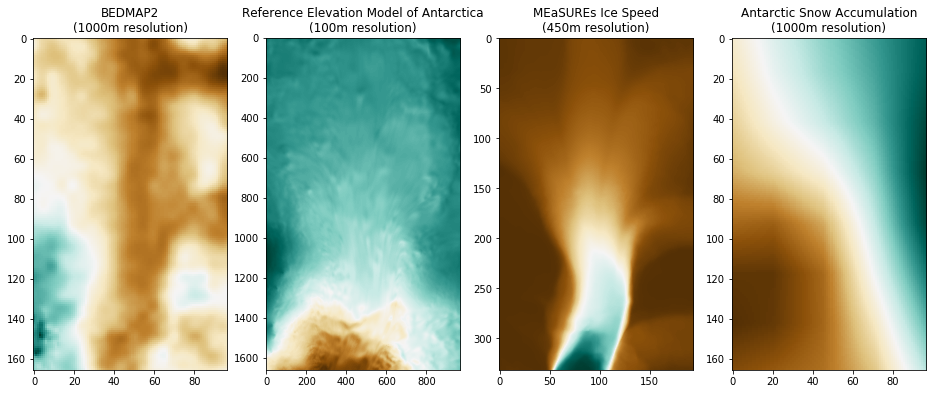

In [9]:
fig, axarr = plt.subplots(nrows=1, ncols=4, squeeze=False, figsize=(16, 12))
axarr[0, 0].imshow(X_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 0].set_title("BEDMAP2\n(1000m resolution)")
axarr[0, 1].imshow(W1_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 1].set_title("Reference Elevation Model of Antarctica\n(100m resolution)")
axarr[0, 2].imshow(np.linalg.norm(W2_tile, axis=(0, 1)), cmap="BrBG")
axarr[0, 2].set_title("MEaSUREs Ice Speed\n(450m resolution)")
axarr[0, 3].imshow(W3_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 3].set_title("Antarctic Snow Accumulation\n(1000m resolution)")
plt.show()

## 1.3 Prepare other interpolated grids for comparison

We'll also have two other grids (interpolated to spatial resolution of 250m) to compare with our DeepBedMap model's prediction.
They are:

- Bicubic interpolated BEDMAP2 (baseline, originally 1000m)
- Bilinear interpolated Synthetic High Resolution Grid from [Graham et al. 2017](https://doi.org/10.5194/essd-9-267-2017) (originally 100m)

In [10]:
cubicbedmap = skimage.transform.rescale(
    image=X_tile[0, 0, 1:-1, 1:-1].astype(np.int32),
    scale=4,  # 4x upscaling
    order=3,  # cubic interpolation
    mode="reflect",
    anti_aliasing=True,
    multichannel=False,
    preserve_range=True,
)
cubicbedmap = np.expand_dims(np.expand_dims(cubicbedmap, axis=0), axis=0)
print(cubicbedmap.shape)

# Save Bicubic Resampled BEDMAP2 to GeoTiff and NetCDF format
cubicbedmap_grid = data_prep.save_array_to_grid(
    outfilepath="model/cubicbedmap",
    window_bound=window_bound,
    array=cubicbedmap[0, :, :, :],
    save_netcdf=True,
)

(1, 1, 656, 380)


In [11]:
S_tile = data_prep.selective_tile(
    filepath="model/hres.tif", window_bounds=[[*window_bound]], interpolate=False
)
print(S_tile.shape)
synthetichr = skimage.transform.rescale(
    image=S_tile[0, 0, :, :].astype(np.int32),
    scale=1 / 2.5,  # 2.5 downscaling
    order=1,  # billinear interpolation
    mode="reflect",
    anti_aliasing=True,
    multichannel=False,
    preserve_range=True,
)
synthetichr = np.expand_dims(np.expand_dims(synthetichr, axis=0), axis=0)
print(synthetichr.shape)

# Save Billinear Resampled Synthetic High Resolution grid to GeoTiff and NetCDF format
synthetichr_grid = data_prep.save_array_to_grid(
    outfilepath="model/synthetichr",
    window_bound=window_bound,
    array=synthetichr[0, :, :, :],
    save_netcdf=True,
)

Tiling: model/hres.tif ... done!
(1, 1, 1640, 950)
(1, 1, 656, 380)


# 2. Predict Bed Elevation

## 2.1 Load trained generator neural network

Fully convolutional networks rock!!
Since we have a fully convolutional model architecture,
we can use the same trained weights on different sized inputs/outputs!
That way we can predict directly on an arbitrarily sized window.

In [12]:
def load_trained_model(
    experiment_key: str = "83748fcb506849d78c275d33f8dd3893",  # or simply use "latest"
    model_weights_path: str = "model/weights/srgan_generator_model_weights.npz",
):
    """
    Returns a trained Generator DeepBedMap neural network model,
    and the hyperparameters that were used to train it.

    The model's weights and hyperparameters settings are retrieved from
    https://comet.ml/weiji14/deepbedmap using an `experiment_key` setting
    which can be set to 'latest' or some 32-character alphanumeric string.
    """
    srgan_train = _load_ipynb_modules("srgan_train.ipynb")

    # Download either 'latest' model weights from Comet.ML or one using experiment_key
    # Will also get the hyperparameters "num_residual_blocks" and "residual_scaling"
    hyperparameters = _download_model_weights_from_comet(
        experiment_key=experiment_key, download_path=model_weights_path
    )

    # Architect the model with appropriate "num_residual_blocks" and "residual_scaling"
    model = srgan_train.GeneratorModel(
        num_residual_blocks=int(hyperparameters["num_residual_blocks"]),
        residual_scaling=float(hyperparameters["residual_scaling"]),
    )

    # Load trained neural network weights into model
    chainer.serializers.load_npz(file=model_weights_path, obj=model)

    return model, hyperparameters

In [13]:
model, _ = load_trained_model()

## 2.2 Make prediction on area of interest

In [14]:
with chainer.using_config(name="enable_backprop", value=False):
    Y_hat = model.forward(x=X_tile, w1=W1_tile, w2=W2_tile, w3=W3_tile).array

In [15]:
# Save BEDMAP3 to GeoTiff and NetCDF format
deepbedmap3_grid = data_prep.save_array_to_grid(
    outfilepath="model/deepbedmap3",
    window_bound=window_bound,
    array=Y_hat[0, :, :, :],
    save_netcdf=True,
)
deepbedmap3_grid = xr.DataArray(
    data=np.flipud(cupy.asnumpy(Y_hat[0, 0, :, :])),
    dims=["y", "x"],
    coords={"y": deepbedmap3_grid.y, "x": deepbedmap3_grid.x},  # for multiple grids
    # coords={"y": groundtruth.y, "x": groundtruth.x},  # for single grid
)
deepbedmap3_grid = xr.open_dataarray("model/deepbedmap3.nc")

In [16]:
# Get elevation difference between DeepBedMap and CubicBedMap
elevdiffmap = deepbedmap3_grid - cubicbedmap_grid
elevdiffmap_grid = data_prep.save_array_to_grid(
    outfilepath="model/elevdiffmap",
    window_bound=window_bound,
    array=elevdiffmap,
    save_netcdf=True,
)

### Plot DeepBedMap prediction alongside other interpolated grids and groundtruth in 2D and 3D

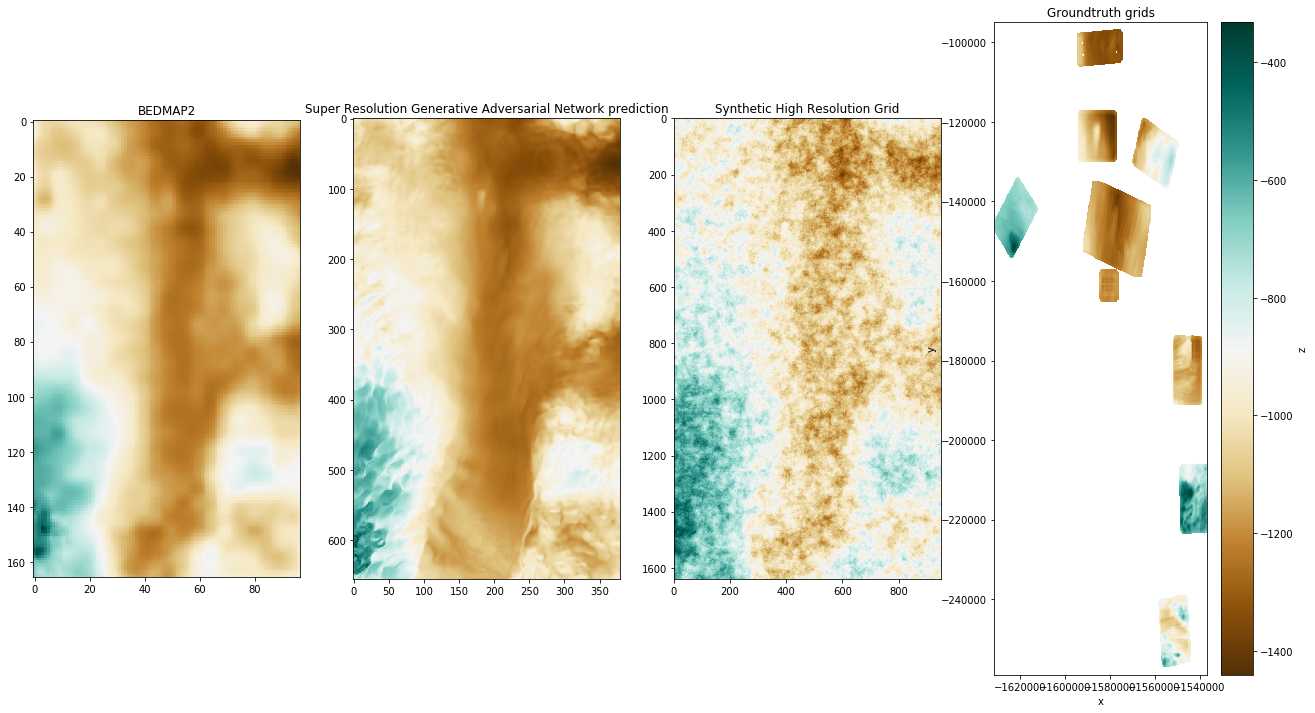

In [17]:
fig, axarr = plt.subplots(nrows=1, ncols=4, squeeze=False, figsize=(22, 12))
axarr[0, 0].imshow(X_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 0].set_title("BEDMAP2")
axarr[0, 1].imshow(Y_hat[0, 0, :, :], cmap="BrBG")
axarr[0, 1].set_title("Super Resolution Generative Adversarial Network prediction")
axarr[0, 2].imshow(S_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 2].set_title("Synthetic High Resolution Grid")
groundtruth.plot(ax=axarr[0, 3], cmap="BrBG")
axarr[0, 3].set_title("Groundtruth grids")
plt.show()

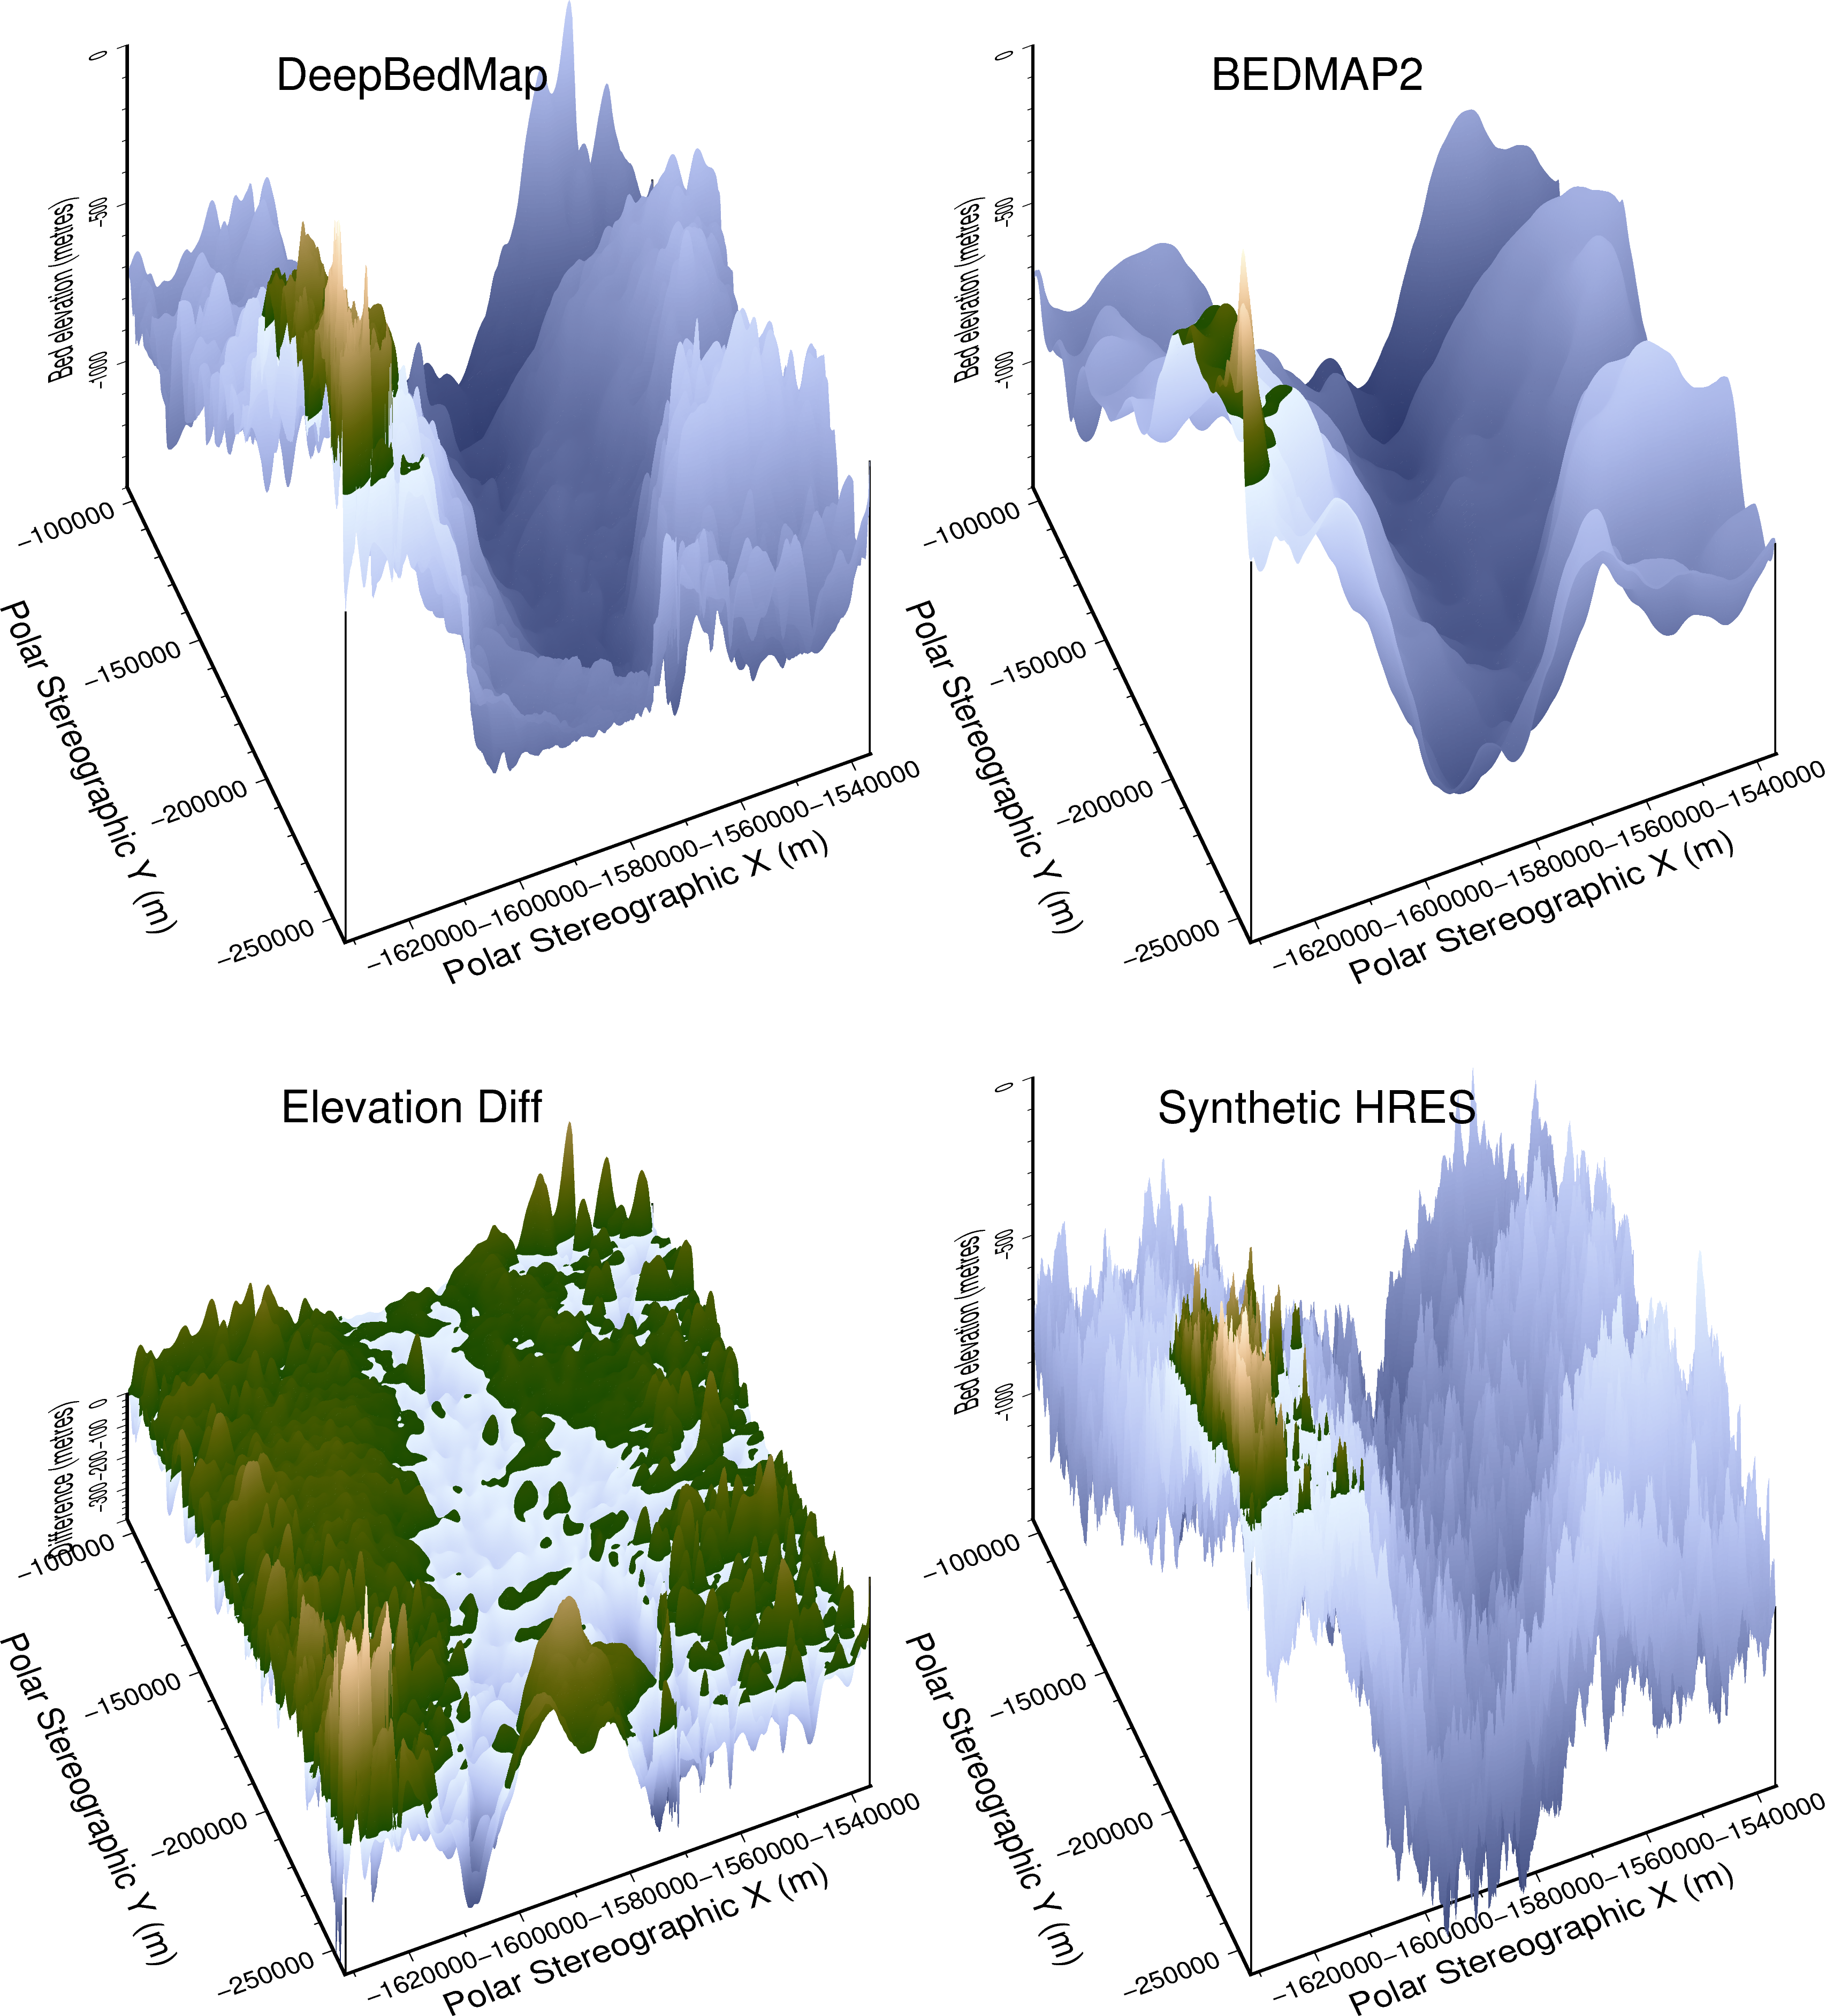

In [18]:
fig = gmt.Figure()
subplot(directive="begin", row=2, col=2, A="+jCT+o-4c/-5c", Fs="9c/9c", M="2c/3c")
plot_3d_view(
    fig=fig,
    img="model/deepbedmap3.nc",  # DeepBedMap
    ax=(0, 0),
    zmin=-1400,
    title="DeepBedMap",  # ours
    zlabel="Bed elevation (metres)",
)
plot_3d_view(
    fig=fig,
    img="model/cubicbedmap.nc",  # BEDMAP2
    ax=(0, 1),
    zmin=-1400,
    title="BEDMAP2",
    zlabel="Bed elevation (metres)",
)
plot_3d_view(
    fig=fig,
    img="model/elevdiffmap.nc",  # DeepBedMap - BEDMAP2
    ax=(1, 0),
    zmin=-400,
    title="Elevation Diff",
    zlabel="Difference (metres)",
)
plot_3d_view(
    fig=fig,
    img="model/synthetichr.nc",  # Synthetic High Resolution product
    ax=(1, 1),
    zmin=-1400,
    title="Synthetic HRES",
    zlabel="Bed elevation (metres)",
)
subplot(directive="end")
fig.savefig(fname="esrgan_prediction.eps", crop=False)
fig.show()

# 3. Elevation 'error' analysis

Here we compare the elevation error (or difference) between our grid and many many points!
We use [PyGMT](https://github.com/GenericMappingTools/pygmt)'s [grdtrack](https://docs.generic-mapping-tools.org/latest/grdtrack.html) to sample the grid along the survey track points.

The survey tracks are basically geographic points (x, y) with an elevation (z)
that were collected from an airplane or ground vehicle crossing Antarctica.
The four grids we sample from all have a spatial resolution of 250m and they are:

- Groundtruth grid (interpolated from our groundtruth points using [surface](https://docs.generic-mapping-tools.org/latest/surface.html))
- DeepBedMap3 grid (predicted from our [Super Resolution Generative Adversarial Network model](/srgan_train.ipynb))
- CubicBedMap grid (interpolated from BEDMAP2 using a [bicubic spline algorithm](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rescale))
- Synthetic High Res grid (created by [Graham et al. 2017](https://doi.org/10.5194/essd-9-267-2017))

References:

- Wessel, P., Smith, W. H. F., Scharroo, R., Luis, J., & Wobbe, F. (2013). Generic Mapping Tools: Improved Version Released. Eos, Transactions American Geophysical Union, 94(45), 409–410. https://doi.org/10.1002/2013EO450001
- Wessel, P. (2010). Tools for analyzing intersecting tracks: The x2sys package. Computers & Geosciences, 36(3), 348–354. https://doi.org/10.1016/j.cageo.2009.05.009

In [19]:
tracks = [data_prep.ascii_to_xyz(pipeline_file=f"{pf}.json") for pf in test_filepaths]
points: pd.DataFrame = pd.concat(objs=tracks)  # concatenate all tracks into one table

In [20]:
df_groundtruth = gmt.grdtrack(
    points=points, grid=groundtruth, newcolname="z_interpolated"
)
# df_deepbedmap3 = gmt.grdtrack(
#     points=points, grid=deepbedmap3_grid, newcolname="z_interpolated"
# )
df_deepbedmap3 = gmt.grdtrack(
    points=points, grid="model/deepbedmap3.nc", newcolname="z_interpolated"
)
df_cubicbedmap = gmt.grdtrack(
    points=points, grid="model/cubicbedmap.nc", newcolname="z_interpolated"
)
df_synthetichr = gmt.grdtrack(
    points=points, grid="model/synthetichr.nc", newcolname="z_interpolated"
)

### Get table statistics

In [21]:
df_groundtruth["error"] = df_groundtruth.z_interpolated - df_groundtruth.z
df_groundtruth.describe()

x              y              z  z_interpolated  \
count  5.242860e+05  524286.000000  524286.000000   524286.000000   
mean  -1.570025e+06 -164891.006356    -987.608968     -987.541573   
std    2.514203e+04   43699.447384     254.286011      253.962068   
min   -1.630901e+06 -256118.350000   -1444.852133    -1439.215672   
25%   -1.584227e+06 -189898.228700   -1188.379363    -1188.262847   
50%   -1.565156e+06 -148015.400850   -1063.172355    -1063.630824   
75%   -1.548072e+06 -128862.578450    -763.656094     -763.516736   
max   -1.536883e+06  -97873.097970    -335.762065     -337.858087   

               error  
count  524286.000000  
mean        0.067395  
std         7.327829  
min      -133.928328  
25%        -2.010458  
50%        -0.017107  
75%         1.957939  
max       263.408316

In [22]:
df_deepbedmap3["error"] = df_deepbedmap3.z_interpolated - df_deepbedmap3.z
df_deepbedmap3.describe()

x              y              z  z_interpolated  \
count  5.242860e+05  524286.000000  524286.000000   524286.000000   
mean  -1.570025e+06 -164891.006356    -987.608968    -1000.542688   
std    2.514203e+04   43699.447384     254.286011      261.859615   
min   -1.630901e+06 -256118.350000   -1444.852133    -1433.379951   
25%   -1.584227e+06 -189898.228700   -1188.379363    -1202.281424   
50%   -1.565156e+06 -148015.400850   -1063.172355    -1079.837265   
75%   -1.548072e+06 -128862.578450    -763.656094     -787.182532   
max   -1.536883e+06  -97873.097970    -335.762065     -320.919735   

               error  
count  524286.000000  
mean      -12.933720  
std        49.341153  
min      -351.980612  
25%       -35.754654  
50%       -12.948500  
75%        13.154136  
max       229.834332

In [23]:
df_cubicbedmap["error"] = df_cubicbedmap.z_interpolated - df_cubicbedmap.z
df_cubicbedmap.describe()

x              y              z  z_interpolated  \
count  5.242860e+05  524286.000000  524286.000000   524286.000000   
mean  -1.570025e+06 -164891.006356    -987.608968    -1004.467615   
std    2.514203e+04   43699.447384     254.286011      238.854563   
min   -1.630901e+06 -256118.350000   -1444.852133    -1426.400722   
25%   -1.584227e+06 -189898.228700   -1188.379363    -1188.213110   
50%   -1.565156e+06 -148015.400850   -1063.172355    -1084.424856   
75%   -1.548072e+06 -128862.578450    -763.656094     -786.345662   
max   -1.536883e+06  -97873.097970    -335.762065     -379.431970   

               error  
count  524286.000000  
mean      -16.858647  
std        68.011194  
min      -392.758124  
25%       -52.133806  
50%       -20.976275  
75%        20.583943  
max       210.218452

In [24]:
df_synthetichr["error"] = df_synthetichr.z_interpolated - df_synthetichr.z
df_synthetichr.describe()

x              y              z  z_interpolated  \
count  5.242860e+05  524286.000000  524286.000000   524286.000000   
mean  -1.570025e+06 -164891.006356    -987.608968     -988.175162   
std    2.514203e+04   43699.447384     254.286011      276.775098   
min   -1.630901e+06 -256118.350000   -1444.852133    -1759.910364   
25%   -1.584227e+06 -189898.228700   -1188.379363    -1194.140637   
50%   -1.565156e+06 -148015.400850   -1063.172355    -1045.691569   
75%   -1.548072e+06 -128862.578450    -763.656094     -772.906113   
max   -1.536883e+06  -97873.097970    -335.762065        2.006351   

               error  
count  524286.000000  
mean       -0.566195  
std       154.842501  
min      -533.979190  
25%      -102.850291  
50%         0.304299  
75%       101.177358  
max       669.322908

### Plot elevation error histogram

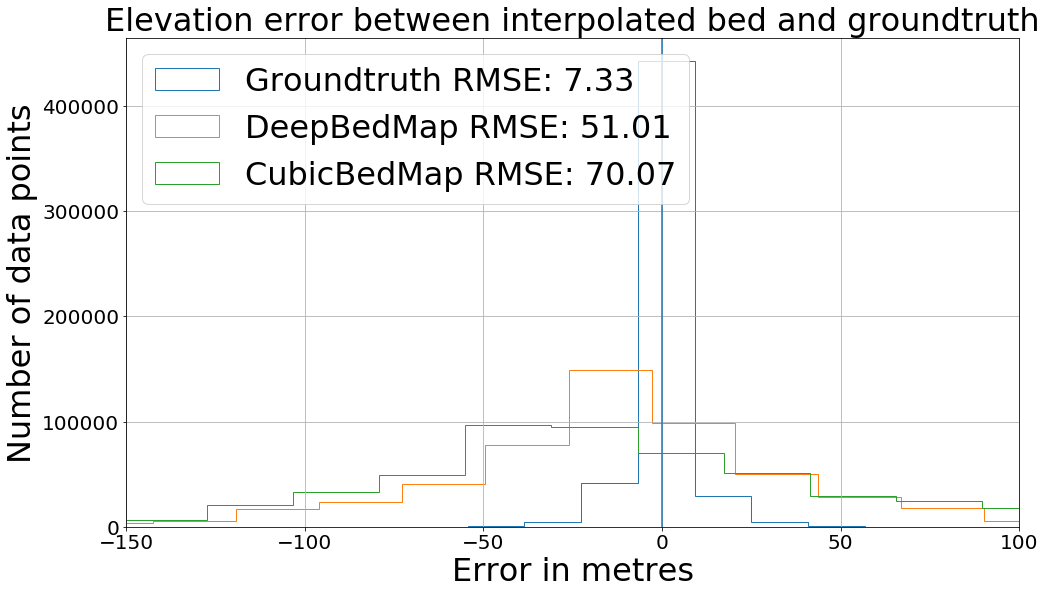

In [25]:
# https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4
rmse_groundtruth = (df_groundtruth.error ** 2).mean() ** 0.5
rmse_deepbedmap3 = (df_deepbedmap3.error ** 2).mean() ** 0.5
rmse_cubicbedmap = (df_cubicbedmap.error ** 2).mean() ** 0.5
rmse_synthetichr = (df_synthetichr.error ** 2).mean() ** 0.5

bins = 50

fig, ax = plt.subplots(figsize=(16, 9))
# ax.set_yscale(value="symlog")
ax.set_xlim(left=-150, right=100)
df_groundtruth.hist(
    column="error",
    bins=25,
    ax=ax,
    histtype="step",
    label=f"Groundtruth RMSE: {rmse_groundtruth:.2f}",
)
df_deepbedmap3.hist(
    column="error",
    bins=25,
    ax=ax,
    histtype="step",
    label=f"DeepBedMap RMSE: {rmse_deepbedmap3:.2f}",
)
df_cubicbedmap.hist(
    column="error",
    bins=25,
    ax=ax,
    histtype="step",
    label=f"CubicBedMap RMSE: {rmse_cubicbedmap:.2f}",
)
"""
df_synthetichr.hist(
    column="error",
    bins=bins,
    ax=ax,
    histtype="step",
    label=f"SyntheticHR RMSE: {rmse_synthetichr:.2f}",
)
"""

ax.set_title("Elevation error between interpolated bed and groundtruth", fontsize=32)
ax.set_xlabel("Error in metres", fontsize=32)
ax.set_ylabel("Number of data points", fontsize=32)
ax.legend(loc="upper left", fontsize=32)
plt.tick_params(axis="both", labelsize=20)
plt.axvline(x=0)

# plt.savefig(fname="elevation_error_histogram.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [26]:
print(f"Groundtruth RMSE: {rmse_groundtruth}")
print(f"DeepBedMap3 RMSE: {rmse_deepbedmap3}")
print(f"SyntheticHR RMSE: {rmse_synthetichr}")
print(f"CubicBedMap RMSE: {rmse_cubicbedmap}")
print(f"Difference      : {rmse_deepbedmap3 - rmse_cubicbedmap}")

Groundtruth RMSE: 7.328131636821937
DeepBedMap3 RMSE: 51.008095856173746
SyntheticHR RMSE: 154.84338835240177
CubicBedMap RMSE: 70.06944906098977
Difference      : -19.061353204816022


# 4. Antarctic-wide **DeepBedMap**

Using our neural network to predict the bed elevation of the whole Antarctic continent!
A previous version (April 2019) presented at EGU2019 can be found in this [issue](https://github.com/weiji14/deepbedmap/issues/133) with reproducible code in this [pull request](https://github.com/weiji14/deepbedmap/pull/136).

In [26]:
# Bounding Box region in EPSG:3031 covering Antarctica
window_bound_big = rasterio.coords.BoundingBox(
    left=-2_700_000.0, bottom=-2_200_000.0, right=2_800_000.0, top=2_300_000.0
)
print(window_bound_big)

BoundingBox(left=-2700000.0, bottom=-2200000.0, right=2800000.0, top=2300000.0)


In [27]:
try:
    X_tile = np.load(file="X_tile_big.npy")
    W1_tile = np.load(file="W1_tile_big.npy")
    W2_tile = np.load(file="W2_tile_big.npy")
    W3_tile = np.load(file="W3_tile_big.npy")
except FileNotFoundError:
    X_tile, W1_tile, W2_tile, W3_tile = get_deepbedmap_model_inputs(
        window_bound=window_bound_big, use_whole_rema=True
    )
    np.save(file="X_tile_big.npy", arr=X_tile)
    np.save(file="W1_tile_big.npy", arr=W1_tile)
    np.save(file="W2_tile_big.npy", arr=W2_tile)
    np.save(file="W3_tile_big.npy", arr=W3_tile)

In [28]:
# Oh we will definitely need a GPU for this
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
model.to_gpu()

In [29]:
# clip Ice Surface Elevation, Velocity and Accummulation values to above 0.0
W1_tile = np.clip(a=W1_tile, a_min=0.0, a_max=None)
W2_tile = np.clip(a=W2_tile, a_min=0.0, a_max=None)
W3_tile = np.clip(a=W3_tile, a_min=0.0, a_max=None)

In [30]:
print(X_tile.shape, W1_tile.shape, W2_tile.shape, W3_tile.shape)

(1, 1, 4502, 5502) (1, 1, 45020, 55020) (1, 2, 9004, 11004) (1, 1, 4502, 5502)


## 4.1 The whole of Antarctica tiler and predictor!!

Antarctica won't fit into our 16GB of GPU memory, so we have to:

1. Cut a 250kmx250km tile and load the data within this one small tile into GPU memory
2. Use our GPU-enabled model to make a prediction for this tile area
3. Repeat (1) and (2) for every tile we have covering Antarctica

In [31]:
@dataclasses.dataclass(frozen=True)
class Shape:
    y: int  # size in y-direction
    x: int  # size in x-direction

In [32]:
# The whole of Antarctica tile and predictor
with chainer.using_config(name="cudnn_deterministic", value=True):
    # Size are in kilometres, same as BEDMAP2's 1km resolution
    final_shape = Shape(y=18000, x=22000)  # 4x that of BEDMAP2
    ary_shape = Shape(y=1000, x=1000)  # 1000pixels * 250m = 250km
    stride = Shape(y=1000, x=1000)  # cut a tile every 1000 metres
    xtrapad = Shape(y=18, x=18)  # extra padding at borders (which will be clipped off)

    Y_hat = np.full(
        shape=(1, final_shape.y, final_shape.x), fill_value=np.nan, dtype=np.float32
    )

    steps = []
    for y_step in range(0, final_shape.y, stride.y):
        for x_step in range(0, final_shape.x, stride.x):
            steps.append(Shape(y=y_step, x=x_step))

    for step in steps:
        # plus `xtrapad.y` pixels and 1 pixel on bottom and top
        y0 = max(0, (step.y // 4) - xtrapad.y - 1)
        y1 = min(final_shape.y // 4, ((step.y + ary_shape.y) // 4) + xtrapad.y + 1)
        # plus `xtrapad.x` pixels and 1 pixel on left and right
        x0 = max(0, (step.x // 4) - xtrapad.x - 1)
        x1 = min(final_shape.x // 4, ((step.x + ary_shape.x) // 4) + xtrapad.x + 1)
        # print(str(x0).zfill(4), str(x1).zfill(4), str(y0).zfill(4), str(y1).zfill(4))

        # Hardcoded crops of BEDMAP2 (X), REMA (W1), MEaSUREs (W2), Accumulation (W3)
        X_tile_crop = model.xp.asarray(a=X_tile[:, :, y0:y1, x0:x1], dtype="float32")
        W1_tile_crop = model.xp.asarray(
            a=W1_tile[:, :, y0 * 10 : y1 * 10, x0 * 10 : x1 * 10], dtype="float32"
        )
        W2_tile_crop = model.xp.asarray(
            a=W2_tile[:, :, y0 * 2 : y1 * 2, x0 * 2 : x1 * 2], dtype="float32"
        )
        W3_tile_crop = model.xp.asarray(a=W3_tile[:, :, y0:y1, x0:x1], dtype="float32")

        # DeepBedMap terrain inference
        with chainer.using_config(name="enable_backprop", value=False):
            Y_pred = model.forward(
                x=X_tile_crop, w1=W1_tile_crop, w2=W2_tile_crop, w3=W3_tile_crop
            )

        try:
            y_slice = slice((y0 + xtrapad.y + 1) * 4, (y1 - xtrapad.y - 1) * 4)
            x_slice = slice((x0 + xtrapad.x + 1) * 4, (x1 - xtrapad.x - 1) * 4)
            Y_pred_uncut: np.ndarray = cupy.asnumpy(Y_pred.array)[0, :, :, :]
            Y_hat[:, y_slice, x_slice] = Y_pred_uncut[
                :, xtrapad.y * 4 : -xtrapad.y * 4, xtrapad.x * 4 : -xtrapad.x * 4
            ]
        except ValueError:
            raise
        finally:
            X_tile_crop = W1_tile_crop = W2_tile_crop = W3_tile_crop = None

## 4.2 Save full map to file

In [33]:
# Save BEDMAP3 to GeoTiff and NetCDF format
# Using LZW compression and int16 instead of float32 to keep things smaller
_ = data_prep.save_array_to_grid(
    window_bound=window_bound_big,
    array=Y_hat.astype(dtype=np.int16),
    outfilepath="model/deepbedmap3_big_int16",
    dtype=np.int16,
    tiled=True,
    compression=rasterio.enums.Compression.lzw.value,  # Lempel-Ziv-Welch, lossless
)

## 4.3 Show *the* DeepBedMap

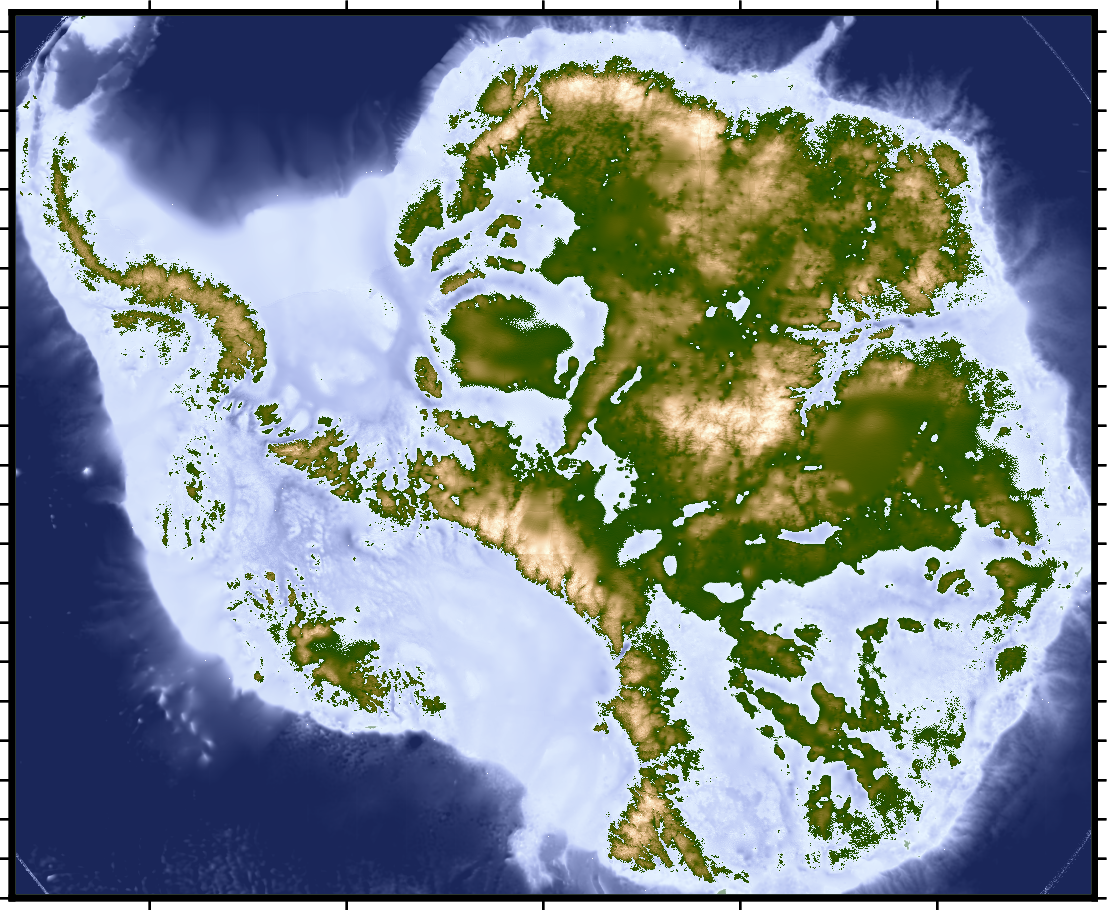

In [34]:
# Adapted from https://docs.generic-mapping-tools.org/latest/gallery/ex42.html
fig = gmt.Figure()
gmt.makecpt(cmap="oleron", series=[-4500, 4500])
fig.grdimage(
    grid="model/deepbedmap3_big_int16.tif",
    region=[-2700000, 2800000, -2200000, 2300000],
    projection="x1:60000000",
    frame="f",  # add minor tick labels only
    cmap=True,
    Q=True,
)
fig.savefig(fname="deepbedmap_dem.png")
fig.show()